# DCR AGN Metric Analysis

G. Richards, B. Martin, W. Yu, C. Peters (August 2020)

This notebook takes simulated quasar colors and DCR slopes.  It takes a single pointing from a single opSim and pretends that all quasars were observed at that point.  Then it simulates an "observation" in both the u and g band at every time of observation, including astrometric error.  Then it fits a line between the "observed" DCR offset and tan Z.  This slope is a function of redshift.  The slope determined from all the observations is compared to the "known" slope.

This needs a fair bit of cleaning up and documenting.  It is also unnecessarily slow.  It would also be good to assign each quasar to a different position on the sky.  Also to enable this to sample many different opSims.

A potential metric could be found by taking 1-2 redshifts where the slope is close to 0 (DCR is not important) -- maybe where the u and g slopes are predicted to have opposite signs.  Then calculate the chi-square (or similar) for the slope determined from all of the observations for all the objects.  It should correlate highly with the number of u- and g-band observations and the airmass of those observations, which may perhaps lead to a simpler metric that doesn't actually involve DCR at all (at least directly).

In [1]:
import math
import astropy
from astropy.io import ascii
import numpy as np
import emcee
from scipy.optimize import minimize
from numpy.random import normal
from numpy.random import uniform
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import richardsplot as rplot
%matplotlib inline
import random
from matplotlib import rc
import pandas as pd
rc('text', usetex=False)

### open files with redshift bins, colors, and DCR slopes

For historical reasons the redshift bins and the colors and DCR slopes are stored in separate data files.  These next few cells just merges them together into a single Pandas DataFrame.

In [2]:
#Table of redshift bins where we have computed the mean colors and DCR slopes.
zfile = 'fittingS82_zshifts.dat'
dfZ = pd.read_csv(zfile)
#dfZ.reset_index(drop=True)
dfZ.head()

,zshifts
0,0.40
1,0.45
2,0.50
3,0.55
4,0.60


In [3]:
#Table of colors and DCR slopes for the above redshifts
datafile = 'fittingS82_zshiftfit.dat'
dfData = pd.read_csv(datafile, index_col=0, header=None, sep=' ').T
dfQSO = dfData.reset_index(drop=True).dropna()
#dfQSO.dropna()

In [4]:
dfDCR = pd.concat([dfZ, dfQSO], axis=1)
dfDCR.head()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
0,0.40,0.3790,0.1143,0.1995,0.2466,0.0012,0.0258
1,0.45,0.2507,0.0644,0.2651,0.2032,0.0053,0.0506
2,0.50,0.2023,0.0410,0.2679,0.1762,0.0002,0.0589
3,0.55,0.3056,0.0252,0.2351,0.1314,-0.0140,0.0357
4,0.60,0.3419,0.0727,0.1867,0.1570,-0.0083,0.0143


In [5]:
#Check to make sure that all the entries are aligned (without the reset_index, there was an offset)
dfDCR.tail()

,zshifts,u-g,g-r,r-i,i-z,u-slope,g-slope
461,3.80,2.1726,1.2433,0.1163,0.1022,-0.0215,-0.0186
462,3.85,1.7256,1.1350,0.1366,0.1582,-0.0029,-0.0126
463,3.90,1.8216,1.1345,0.1156,0.1389,0.0225,-0.0221
464,3.95,2.3703,1.3296,0.1086,0.0744,-0.0089,-0.0576
465,4.00,2.5010,1.4278,0.1483,0.0881,-0.0468,-0.0655


---

The next cell sets the astrometric error in the u and g bands.  This needs to be changed for different simulated magnitudes.  Someone also needs to determine how the astrometric errors map to u- and g-band magnitudes for LSST

For SDSS the astrometric error at r~22 was 0.100 arcsec (Pier et al. 2003).

N.B.  This error array gets overridden in the functions below!!

In [6]:
astrometric_error = [0.035, 0.025]  #Units: arcsec
#astrometric_error = np.multiply(astrometric_error, [2,2])
print(astrometric_error)

[0.035, 0.025]


This next cell determines the airmasses and filters from an opSim.  It needs to be changed and incorporated into the MAF framework so that many opSims can be tested.  It should also assign each of the redshifts above to a random position on the sky.  Ideally more like each redshift gets ~100 random positions.  

For now, just using the one random position once for each redshift.

In [7]:
# Weixiang: import opsim cadence after fix for python2
ids = pd.read_csv('id.csv')
cad = pd.read_csv('dcr_all.csv')

#pick random object's cadence
random_cadence = random.randint(0,max(cad['id']))
# assign the cadence of random object to dcr_0
dcr_0 = cad[cad['id'] == random_cadence].copy()
obs_g = dcr_0[dcr_0['filter'] == 'g']
obs_u = dcr_0[dcr_0['filter'] == 'u']
obs = np.concatenate((obs_g, obs_u))

Extract the airmass and filters for each observation

In [8]:
# Weixiang: modified the item index to match the order of columns in new file
airmasses = np.array([item[3] for item in obs])
filters = np.array([item[5] for item in obs])

In [9]:
print(len(airmasses),len(filters))
print(airmasses[:5])
print(filters[:5])

136 136
[1.00411623 1.05821364 1.02261616 1.01825175 1.02192147]
['g' 'g' 'g' 'g' 'g']


## generate observed slopes from true slopes and observations

*lnlike* calculates the loglikelihood, *lnprior* creates a prior on our linear fits, *lnprob* adds the prior to lnlike

*run_fit* runs the mcmc walkers over a range of linear fits and selects the median as the best fit and half the  difference between 16th and 84th percentiles as the error.

This mcmc approach for the linear regression problem is unnecessarily complicated/slow for the purpose for which it is being used.

N.B.  run_fit is computing the slope in the offset vs. tanZ plane for a **single** object

In [10]:
def lnlike(theta, x, y, yerr):
    m, lnf = theta
    model = m*x
    inv_sigma2 = 1.0/(yerr**2. + model**2.*np.exp(2.*lnf))
    return -0.5*(np.sum(((y-model)**2.*inv_sigma2 - np.log(inv_sigma2))))

def lnprior(theta):
    m, lnf = theta
    if (-1.0 < m < 1.0) and (-100.0 < lnf < 100.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def run_fit(tanZList, RList, RerrList):
    nll = lambda *args: -lnprob(*args)
    x = np.copy(tanZList)
    y = np.copy(RList)
    yerr = np.copy(RerrList)
    #first do a simple minimization to get starting values for mcmc
    pm = np.random.choice([-1.0,1.0], size=len(x), replace=True)
    result = minimize(nll, [-0.001, np.log(0.5)], args=(x, y, yerr))
    m_ml, lnf_ml = result["x"]
    #now run mcmc
    ndim, nwalkers = 2, 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    ms = samples[np.random.randint(len(samples), size=100)][:,0]
    # return the median walker as the best slope and the half the 16-84th percentiles as the error
    m_mcmc, lnf_mcmc = map(lambda v: (v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    merr_mcmc, lnf_mcmc = map(lambda v: (0.5*(v[2]-v[0])), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
    return m_mcmc, merr_mcmc

*dcrSlopeCalc* is computing the slope in the offset vs. tanZ plane for **all** the objects, calling *run_fit* for each

In [14]:
def dcrSlopeCalc(airmasses, filters, test_quasars, makePlot = True):
    #Note that the next line overrides the cell above!!
    astrometric_error = [0.035, 0.025]
    
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))
    imgNumString = 0
    xAxis = np.linspace(0, 2.0, 100)
    for i in range(len(test_quasars)):
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
    
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
    
        for j, airmass in enumerate(airmasses):
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
    
        # fit a stright line through the x and y values, using the y-err values
        m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u, RList_u, RerrList_u)
        m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g, RList_g, RerrList_g)
        if makePlot == True:
            bestFitLine_u = m_mcmc_u*xAxis + 0.0
            bestFitLine_g = m_mcmc_g*xAxis + 0.0
            trueFitLine_u = true_slope_u*xAxis + 0.0
            trueFitLine_g = true_slope_g*xAxis + 0.0
            plt.figure(figsize=(12,12))
            plt.subplot(121)
            plt.title('u-band observations + fit')
            plt.scatter(tanZList_u, RList_u, label = 'Observations')
            plt.plot(xAxis, bestFitLine_u, label='Fit Line')
            plt.plot(xAxis, trueFitLine_u, label = 'True Line')
            plt.legend()
            plt.xlabel('Tan(Z)')
            plt.ylabel('delta R')
            plt.xlim(0.0, 2.0)
            plt.scatter(x=tanZList_u, y=RList_u)
            plt.subplot(122)
            plt.title('g-band observations + fit')
            plt.scatter(tanZList_g, RList_g, label = 'Observations')
            plt.plot(xAxis, bestFitLine_g, label = 'Fit Line')
            plt.plot(xAxis, trueFitLine_g, label = 'True Line')
            plt.xlabel('Tan(Z)')
            plt.xlim(0.0, 2.0)
            plt.scatter(x=tanZList_g, y=RList_g)
            filename = "TanZimgFiles/airmassOffsetFit"+str(len(airmasses))+"_"+"{:0>5d}".format(imgNumString)
            plt.savefig(filename)
            plt.clf()
            plt.close()
            imgNumString += 1
        obs_slopes_u[i] = m_mcmc_u
        obs_slopes_uerr[i] = merr_mcmc_u
        obs_slopes_g[i] = m_mcmc_g
        obs_slopes_gerr[i] = merr_mcmc_g
    if makePlot == True:
        deltaSlope_u = []
        deltaSlope_g = []
        for i in range(len(obs_slopes_u)):
            deltaSlope_u = np.append(deltaSlope_u, test_quasars['u-slope'][i] - obs_slopes_u[i])
        for i in range(len(obs_slopes_g)):
            deltaSlope_g = np.append(deltaSlope_g, test_quasars['g-slope'][i] - obs_slopes_g[i])
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.hist(deltaSlope_u, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope u-band '+str(len(airmasses)))
        plt.subplot(122)
        plt.hist(deltaSlope_g, bins=50, range=(-0.3,0.3))
        plt.title('Delta Slope g-band '+str(len(airmasses)))
        filename = "DeltaSlopeimgFiles/deltaSlopeHist" + str(len(airmasses))
        plt.savefig(filename)
    return obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr

The next cell actually calls the code that computes the slopes.

This is taking every object in the test set and treating them as if they were observed at the same position on the sky from the simulation.  We need to change that.

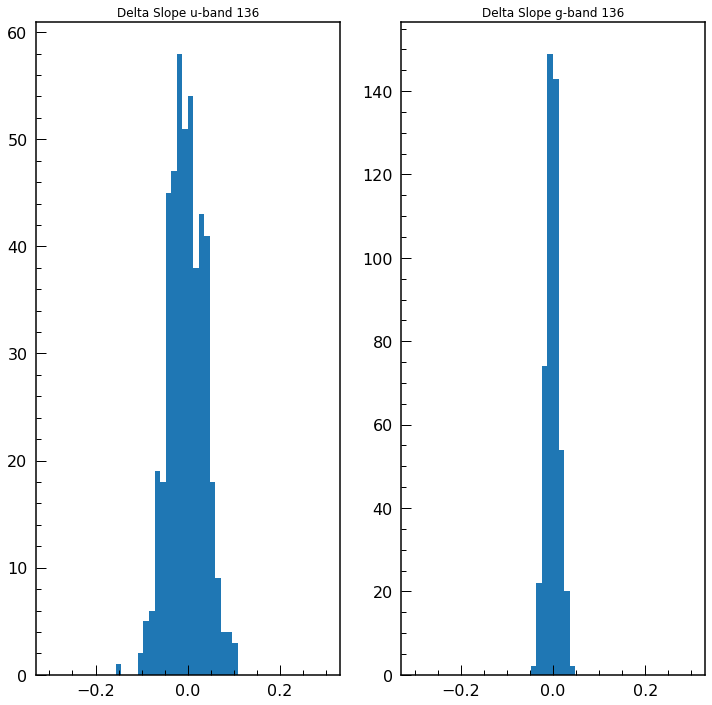

In [15]:
obs_slopes_u, obs_slopes_uerr, obs_slopes_g, obs_slopes_gerr = dcrSlopeCalc(airmasses, filters, dfQSO, makePlot=True)

The next cell makes a plot of the predicted DCR slope for all of the test objects and overplots that information on a plot of the true DCR slopes.

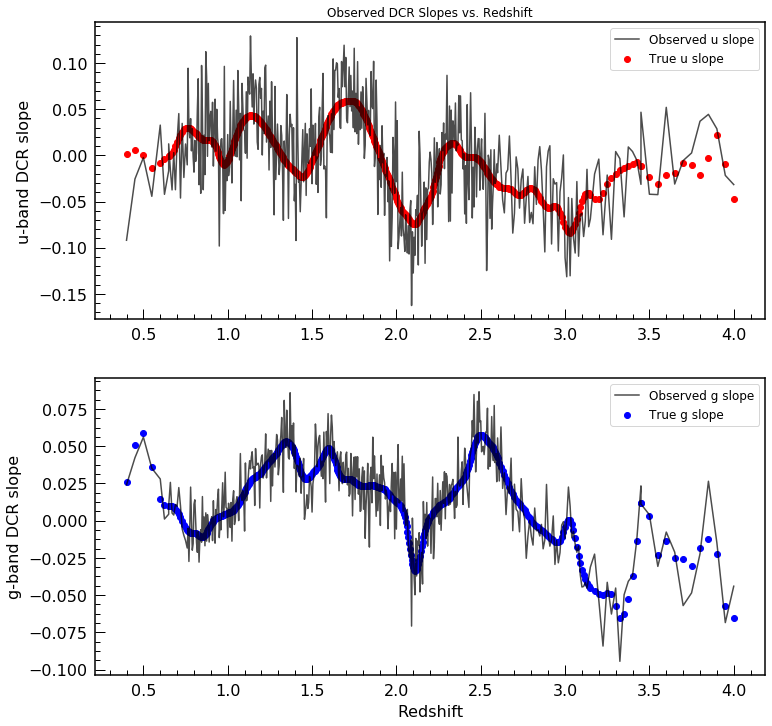

In [16]:
sort_indices = np.argsort(dfDCR['zshifts'])
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.title('Observed DCR Slopes vs. Redshift')
plt.scatter(dfDCR['zshifts'][sort_indices], dfDCR['u-slope'][sort_indices], color='red', label = 'True u slope')
plt.plot(dfDCR['zshifts'][sort_indices], obs_slopes_u[sort_indices], color='black', label = 'Observed u slope', alpha=0.7)
plt.legend(loc='upper right')
plt.ylabel('u-band DCR slope')
plt.subplot(212)
plt.scatter(dfDCR['zshifts'][sort_indices], dfDCR['g-slope'][sort_indices], color='blue', label = 'True g slope')
plt.plot(dfDCR['zshifts'][sort_indices], obs_slopes_g[sort_indices], color='black', label = 'Observed g slope', alpha=0.7)
plt.legend(loc='upper right')
plt.ylabel('g-band DCR slope')
plt.xlabel('Redshift')
plt.savefig('dcr1510.png')

---

The above shows the slopes calculated for each object in each reshift bin. 

*slopeProgressionCalcDF* computes how the slope predictions change wtih each new observation.  We are going to compute this for each object, so this will take quite some time.  For right now, each object is treated as being at the same point on the sky.  Note that the way this is coded, it won't work for objects with different number of observations (i.e., different positions on the sky).

In [17]:
#N.B.  makePlot=True generates a LOT of plots.  One for each observation.  Use with care!
#This is NOT fast.
def slopeProgressionCalcDF(airmasses, filters, test_quasars):
    dfSlopes_u  = pd.DataFrame()
    dfSlopes_g  = pd.DataFrame()
    astrometric_error = [0.035, 0.025]
    obs_slopes_u    = np.zeros((len(test_quasars)))
    obs_slopes_uerr = np.zeros((len(test_quasars)))
    obs_slopes_g    = np.zeros((len(test_quasars)))
    obs_slopes_gerr = np.zeros((len(test_quasars)))
    diff_array_u = []
    diff_array_g = []
    num_obs_array_u = []
    num_obs_array_g = []
    imgNumString = 0
    xAxis = np.linspace(0, 2.0, 100)
    for i in range(len(test_quasars)):
        #print(i)
        slopes_array_u = []
        slopes_array_g = []
        redshift = test_quasars['zshifts'][i]
        true_slope_u = test_quasars['u-slope'][i]
        true_slope_g = test_quasars['g-slope'][i]
        print(i,redshift, true_slope_u, true_slope_g)
        
        tanZList_u = np.array([])
        RerrList_u = np.array([])
        RList_u = np.array([])
        tanZList_g = np.array([])
        RerrList_g = np.array([])
        RList_g = np.array([])
        for j, airmass in enumerate(airmasses):
            #print(j,airmasses[j],filters[j])
            #print(j,airmasses,filters)
            tanZ_obs = np.tan(np.arccos(1.0/airmass)) #tangent of zenith angle of this observation
            #print("tan Z",tanZ_obs)
            if filters[j] == 'u':
                #calculate the observed offset
                #random scatter around the true offset using a normal distribution with the astrometric error as the standard deviation
                R_obs = normal(true_slope_u*tanZ_obs, astrometric_error[0])
                #print("R_obs u",R_obs)
                tanZList_u = np.append(tanZList_u, tanZ_obs)              #list of x axis values
                RerrList_u = np.append(RerrList_u, astrometric_error[0])  #list of y axis error values
                RList_u = np.append(RList_u, R_obs)                       #list of y axis values
            if filters[j] == 'g':
                R_obs = normal(true_slope_g*tanZ_obs, astrometric_error[1])
                #print("R_obs g",R_obs)
                tanZList_g = np.append(tanZList_g, tanZ_obs)
                RerrList_g = np.append(RerrList_g, astrometric_error[1])
                RList_g = np.append(RList_g, R_obs)
        NumObsPerBand = 2
        #print(len(tanZList_u),len(tanZList_g))
        while ((NumObsPerBand <= len(tanZList_u)) or (NumObsPerBand <= len(tanZList_g))):
            if NumObsPerBand < len(tanZList_g):
                tanZList_g_copy = tanZList_g[:NumObsPerBand]
                RList_g_copy = RList_g[:NumObsPerBand]
                RerrList_g_copy = RerrList_g[:NumObsPerBand]
            else:
                tanZList_g_copy = tanZList_g
                RList_g_copy = RList_g
                RerrList_g_copy = RerrList_g
            if NumObsPerBand < len(tanZList_u):
                tanZList_u_copy = tanZList_u[:NumObsPerBand]
                RList_u_copy = RList_u[:NumObsPerBand]
                RerrList_u_copy = RerrList_u[:NumObsPerBand]
            else:
                tanZList_u_copy = tanZList_u
                RList_u_copy = RList_u
                RerrList_u_copy = RerrList_u
            
            #print(i,j,tanZList_u_copy,RList_u_copy)
            m_mcmc_u, merr_mcmc_u = run_fit(tanZList_u_copy, RList_u_copy, RerrList_u_copy)
            m_mcmc_g, merr_mcmc_g = run_fit(tanZList_g_copy, RList_g_copy, RerrList_g_copy)
            #End while loop
            
            slopes_array_u = np.append(slopes_array_u, abs(m_mcmc_u - true_slope_u))
            slopes_array_g = np.append(slopes_array_g, abs(m_mcmc_g - true_slope_g))
            NumObsPerBand += 1
            #print(i,slopes_array_u)
        #End airmass loop
        dfSlopes_u[i] = slopes_array_u
        dfSlopes_g[i] = slopes_array_g   
    #End quasar loop
    return dfSlopes_u, dfSlopes_g
    

The next cell calls the function above.  Right now just using 5 objects since it takes a LONG time to run.  This needs to be fixed.

In [18]:
dfSlopes_u, dfSlopes_g = slopeProgressionCalcDF(airmasses, filters, dfDCR[:5])

0 0.4 0.0012 0.0258
1 0.45 0.0053 0.0506
2 0.5 0.0002 0.0589
3 0.55 -0.014 0.0357
4 0.6 -0.0083 0.0143


Plot the results from the above.

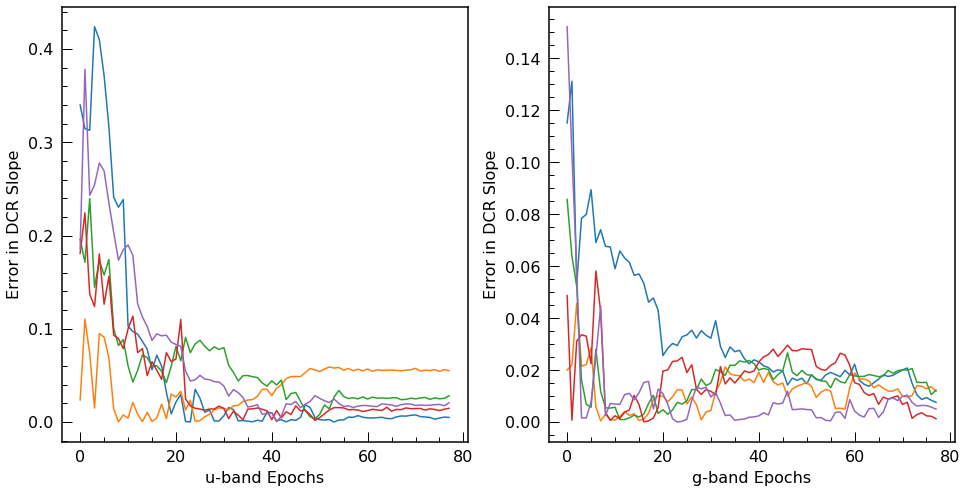

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

dfSlopes_u.plot(ax=ax1,legend=False)
ax1.set_xlabel('u-band Epochs')
ax1.set_ylabel('Error in DCR Slope')

dfSlopes_g.plot(ax=ax2, legend=False)
ax2.set_xlabel('g-band Epochs')
ax2.set_ylabel('Error in DCR Slope')
plt.savefig('DCRprogression.png')

#N.B.  It would be useful to make the color map the redshift in order to be able to see redshift trends.